# COVID severity analysis on PAC design

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

In [3]:
import diff2atlas

Global seed set to 0


In [59]:
figdir = resdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/COVID_analysis_severity/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [5]:
sc.settings.figdir = figdir

In [6]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)


In [7]:
%load_ext rpy2.ipython

In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

plotting utils

In [9]:
from adjustText import adjust_text
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

In [10]:
def plot_w_ggplot(r_fct_str, args, figdir='.', pl_name='plot', pl_width=8, pl_height=8):

    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP

    r_pkg = STAP(r_fct_str, "r_pkg")
    #this was needed for the code to run on jhub
    #if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    pl = r_pkg.plot_func(args)
    
    ggsave_str = '''
    save_plot <- function(pl, figdir, pl_name, pl_width, pl_height){
        pl + 
        ggsave(file.path(figdir, paste0(pl_name, ".png")), width=pl_width, height=pl_height)  +
        ggsave(file.path(figdir, paste0(pl_name, ".pdf")), width=pl_width, height=pl_height)
    }
    
    '''
    r_save = STAP(ggsave_str, "r_save")
    r_save.save_plot(pl, figdir, pl_name=pl_name, pl_width=pl_width, pl_height=pl_height)
    

## Load preprocessed dataset

Generated in `20220713_COVID_design.ipynb`

In [11]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_COVID/'
adata = milopy.utils.read_milo_adata(filepath=data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.h5ad')

In [12]:
adata.uns['nhood_neighbors_key'] = None

In [13]:
## Group annotations
all_annos = adata.obs['author_cell_type'].unique().tolist()
anno_groups = {}

## NKt
anno_groups['CD4 T'] = [x for x in all_annos if x.startswith("CD4.")]
anno_groups['CD8 T'] = [x for x in all_annos if x.startswith("CD8.")]
anno_groups['unconv T'] = ['MAIT', 'NKT', 'gdT', 'Treg']
anno_groups['NK'] = [x for x in all_annos if x.startswith("NK_")]
anno_groups['ILC'] = [x for x in all_annos if x.startswith("ILC")]

## B cells
anno_groups['B cells'] = [x for x in all_annos if x.startswith("B_")]
anno_groups['plasma'] = [x for x in all_annos if x.startswith("Plasma_cell")] + ['Plasmablast']

## blood cells
anno_groups['HSPC'] = [x for x in all_annos if x.startswith("HSC_")]
anno_groups['ery/mk'] = ['Platelets', 'RBC']

## Myeloid
anno_groups['DC'] = [x for x in all_annos if x.startswith("DC")] + ["ASDC", 'pDC']
anno_groups['monos'] = [x for x in all_annos if x not in sum(anno_groups.values(), [])]

anno_group_rev = {x:k for k,v in anno_groups.items() for x in v}
anno_group_order = anno_groups.keys()

## Run Milo analysis on severity

In [14]:
## Convert severity to continuous variable
order_severity = ['Healthy', 'Asymptomatic', 'Mild', "Moderate", "Severe", "Critical"]
adata.obs['severity_cont'] = adata.obs['Status_on_day_collection_summary'].copy()
## turn LPS treatment to nan
adata.obs['severity_cont'] = np.where(adata.obs['severity_cont'].isin(order_severity), adata.obs['severity_cont'], np.nan)
adata.obs['severity_cont'] = adata.obs['severity_cont'].astype("category")
adata.obs['severity_cont'] = adata.obs['severity_cont'].cat.reorder_categories(order_severity).cat.codes

milopy.utils.add_covariate_to_nhoods_var(adata, ['severity_cont'])

In [15]:
# milopy.core.DA_nhoods(adata, design = '~ Site + severity_DA', model_contrasts = 'severity_DAAsymptomatic-severity_DAHealthy')
# adata.uns['nhood_adata'].obs[f'logFC_asymp'] = adata.uns['nhood_adata'].obs['logFC'].copy()
# adata.uns['nhood_adata'].obs[f'SpatialFDR_asymp'] = adata.uns['nhood_adata'].obs['SpatialFDR'].copy()

In [16]:
for i,sev in enumerate(order_severity):
    if i > 0:
        print(f"DA test - {sev}")
        milopy.utils.add_covariate_to_nhoods_var(adata, ['severity_cont'])
        adata.uns['nhood_adata'].var['severity_cont'] = adata.uns['nhood_adata'].var['severity_cont'].astype('int')
        
        exclude_lps = adata.uns['nhood_adata'].var['severity_cont'] >= 0
        keep_samples = adata.uns['nhood_adata'].var_names[exclude_lps & (adata.uns['nhood_adata'].var['severity_cont'] <= i)]
        milopy.core.DA_nhoods(adata, design = '~ Site + severity_cont', 
                              subset_samples=keep_samples)
        adata.uns['nhood_adata'].obs[f'logFC_{sev}'] = adata.uns['nhood_adata'].obs['logFC'].copy()
        adata.uns['nhood_adata'].obs[f'SpatialFDR_{sev}'] = adata.uns['nhood_adata'].obs['SpatialFDR'].copy()

DA test - Asymptomatic
DA test - Mild
DA test - Moderate
DA test - Severe
DA test - Critical


### Save results 

In [17]:
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs

,index_cell,kth_distance,nhood_annotation,nhood_annotation_frac,SpatialFDR,nhood_IFN_signature,logFC_Asymptomatic,SpatialFDR_Asymptomatic,logFC_Mild,SpatialFDR_Mild,...,SpatialFDR_Moderate,logFC_Severe,SpatialFDR_Severe,logFC,logCPM,F,PValue,FDR,logFC_Critical,SpatialFDR_Critical
0,10_1038_s41591_021_01329_2-S12_GACTGCGTCCTTTCGG-1,0.882193,NK_16hi,0.982558,0.415595,-0.002200,0.157223,0.973210,-0.332594,0.454460,...,0.471969,-0.161176,0.424592,-0.130734,8.862654,1.894709,0.170013,0.398919,-0.130734,0.415595
1,10_1038_s41591_021_01329_2-S11_CGGTTAATCGGATGGA-1,0.713938,CD8.Naive,0.428571,0.092539,-0.065815,-0.617565,0.826834,0.057872,0.924706,...,0.721263,-0.174537,0.395694,-0.239716,9.022122,5.887983,0.016016,0.083371,-0.239716,0.092539
2,10_1038_s41591_021_01329_2-S12_CTGTGCTAGCTCCTCT-1,0.898555,B_naive,0.370968,0.941939,-0.075459,-0.147530,0.977665,-0.070021,0.916344,...,0.649906,-0.103232,0.674878,0.019103,8.880465,0.037489,0.846645,0.938440,0.019103,0.941939
3,10_1038_s41591_021_01329_2-S11_CTTCTCTGTACTTAGC-1,0.768485,CD4.CM,0.523810,0.713165,-0.067536,-0.341551,0.942384,0.151110,0.773942,...,0.969858,0.012108,0.970125,0.074012,8.908513,0.565868,0.452677,0.701341,0.074012,0.713165
4,10_1038_s41591_021_01329_2-S12_CGGACACTCAGCTTAG-1,0.629925,CD4.CM,0.750000,0.860194,-0.140777,-0.511469,0.876407,-0.749319,0.033948,...,0.847912,-0.132964,0.577003,-0.047052,8.903845,0.166776,0.683374,0.852927,-0.047052,0.860194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4784,10_1038_s41591_021_01329_2-TAGCCGGCAACACGCC-ne...,0.871801,CD8.TE,0.532258,0.558459,-0.005379,0.086097,0.986249,0.261010,0.601607,...,0.469308,0.136616,0.553928,0.107893,8.875025,1.137986,0.287199,0.542135,0.107893,0.558459
4785,10_1038_s41591_021_01329_2-GCATGTAAGCTTATCG-ne...,0.682758,CD4.CM,0.419512,0.350666,-0.071640,-0.732103,0.789819,-0.166028,0.732574,...,0.314714,-0.194171,0.291440,-0.141068,8.930402,2.390574,0.123447,0.333737,-0.141068,0.350666
4786,10_1038_s41591_021_01329_2-GTGCAGCAGTGTGGCA-ne...,1.165385,gdT,0.561151,0.065422,-0.049021,0.240014,0.963522,-0.147145,0.799281,...,0.078711,-0.276968,0.160155,-0.270063,8.726812,6.758480,0.009936,0.058265,-0.270063,0.065422
4787,10_1038_s41591_021_01329_2-GCGCGATTCAAGAAGT-ne...,1.026302,NK_16hi,0.683871,0.692801,0.034771,-1.617502,0.362390,-0.433773,0.298138,...,0.546274,-0.071600,0.766797,-0.074788,8.775701,0.626291,0.429536,0.680691,-0.074788,0.692801


In [18]:
nhood_adata.write_h5ad(data_dir + 'PBMC_COVID.subsample500cells.design.query_PC_refA.post_milo.nhood_adata.severity.h5ad')

### Compare results across all nhoods

In [18]:
logFC_df = nhood_adata.obs[ [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
logFC_df = logFC_df.dropna()
logFC_df['nhood_id'] = logFC_df.index.copy()
nhood_order = logFC_df.sort_values('logFC_Critical')['nhood_id'].values

FDR_df = nhood_adata.obs[ [f'SpatialFDR_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
FDR_df = FDR_df.dropna()
FDR_df['nhood_id'] = FDR_df.index.copy()

## scale logFC for each test
lfc_df = logFC_df[[f'logFC_{sev}' for sev in order_severity[1:]]]
scaled_lfc_df = lfc_df/lfc_df.std(0)
logFC_df.loc[:,[f'logFC_{sev}' for sev in order_severity[1:]]] = scaled_lfc_df

## Select nhoods with at least one signif DA
signif_nhoods = (FDR_df[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0

## Get clustered order
a = sns.clustermap(logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]]].T, cmap='RdBu_r', figsize=(25,4), 
               vmax=5, vmin=-5, 
               row_cluster=False
              )
order_index = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]]].index[a.dendrogram_col.reordered_ind]

lfc_df = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_id']]

lfc_df = lfc_df.loc[order_index]

## Make cell type identity heatmap (1/0)
dummy_anno_df = logFC_df[['nhood_annotation', 'nhood_id']].loc[order_index]
dummy_anno_df['anno_group'] = [anno_group_rev[x] for x in dummy_anno_df['nhood_annotation']]
anno_group_order = list(anno_group_order)

lfc_df = pd.merge(lfc_df, dummy_anno_df)
lfc_df

In [21]:
plot_lfc_heatmap_str = '''
    plot_func <- function(args){
        lfc_df <- args[[1]]
        anno_group_order <- args[[2]]
        order_severity <- args[[3]]
        anno_hm <- lfc_df[c('nhood_id', 'nhood_annotation', 'anno_group')] %>%
            mutate(index = factor(nhood_id, levels=nhood_id)) %>%
            mutate(anno_group = factor(anno_group, levels=unlist(anno_group_order))) %>%
            ggplot(aes(index, nhood_annotation)) +
            geom_tile() +
            facet_grid(anno_group~., scales='free', space='free') +
            theme_grey(base_size=21) +
            remove_x_axis() +
            theme(strip.text.y=element_text(angle=0))

        lfc_hm <- lfc_df %>%
            select( - c('nhood_annotation', 'anno_group') ) %>%
            mutate(index = factor(nhood_id, levels=nhood_id)) %>%
            pivot_longer(cols= - c(index, nhood_id), values_to='scaled_logFC', names_to='Severity') %>%
            mutate(Severity = str_remove(Severity, 'logFC_')) %>%
            mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
            ggplot(aes(index, Severity, fill=scaled_logFC)) +
            geom_tile() +
            scale_fill_gradient2(midpoint=0, high='red', low='blue') +
            theme_grey(base_size=30) +
            remove_x_axis() 

        (anno_hm / lfc_hm) +
        plot_layout(heights=c(2,1))
    }
    '''
# ggsave(paste0(figdir, 'clustered_lfc_heatmap_annotated.pdf'), width = 25, height=15)
plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df, anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated',
              pl_width=25, pl_height=15)

plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.nhood_annotation == 'B_naive'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.Bnaive',
              pl_width=12, pl_height=7)

plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'B cells'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.Bcells',
              pl_width=12, pl_height=7)

plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'monos'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.monos',
              pl_width=15, pl_height=7)


plot_w_ggplot(plot_lfc_heatmap_str, [lfc_df[lfc_df.anno_group == 'CD8 T'], anno_group_order, order_severity], figdir=figdir,
              pl_name = 'clustered_lfc_heatmap_annotated.CD8T',
              pl_width=15, pl_height=7)

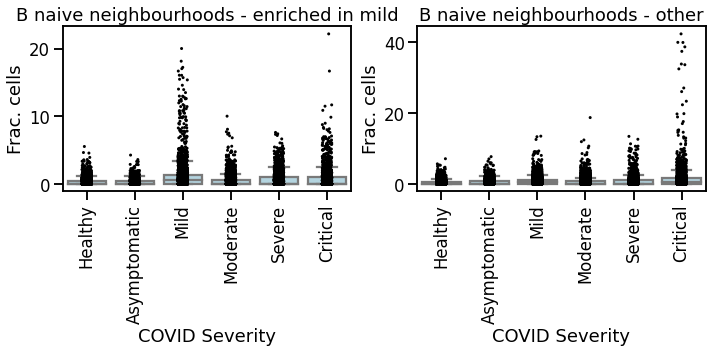

In [22]:
def plot_nhood_counts_by_severity(nhood_adata, n_ixs, normalize=False):
    tot_cells = np.array(nhood_adata[n_ixs].X.sum(1)).ravel()
    pl_df = pd.DataFrame(nhood_adata[n_ixs].X.A, columns = nhood_adata.var_names)
    if normalize:
        pl_df = (pl_df.T/tot_cells).T * 100
    pl_df = pl_df.melt(var_name='sample_id', value_name='n_cells')
    pl_df = pd.merge(pl_df, nhood_adata.var)
    pl_df = pl_df[pl_df['severity_cont'] >= 0]
    pl_df['log_n_cells'] = np.log1p(pl_df['n_cells'])
    pl_df['severity_cont'] = [order_severity[i] for i in pl_df['severity_cont']]
    pl_df['severity_cont'] = pl_df['severity_cont'].astype('category').cat.reorder_categories(order_severity)
    sns.boxplot(data=pl_df, x='severity_cont', y='n_cells', color='lightblue', showfliers = False);
    sns.stripplot(data=pl_df, x='severity_cont', y='n_cells', color='black', s=3);
    plt.xticks(rotation = 90); 
    plt.xlabel("COVID Severity"); 
    if normalize:
        plt.ylabel('Frac. cells');
    else:
        plt.ylabel('# cells');

lfc_df_bnaive = lfc_df[lfc_df.nhood_annotation == 'B_naive'].copy()
nhood_ixs = lfc_df[lfc_df.nhood_annotation == 'B_naive']['nhood_id'][0:100]

## Filter by significance
nhood_ixs = nhood_ixs.values[nhood_adata.obs.loc[nhood_ixs]['SpatialFDR_Mild'] < 0.1]

with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,2,1);
    plot_nhood_counts_by_severity(nhood_adata, nhood_ixs, normalize=True);
    plt.title("B naive neighbourhoods - enriched in mild");
    plt.subplot(1,2,2);
    plot_nhood_counts_by_severity(nhood_adata, lfc_df_bnaive['nhood_id'][~lfc_df_bnaive['nhood_id'].isin(nhood_ixs)], normalize=True);
    plt.title("B naive neighbourhoods - other")
    plt.tight_layout()


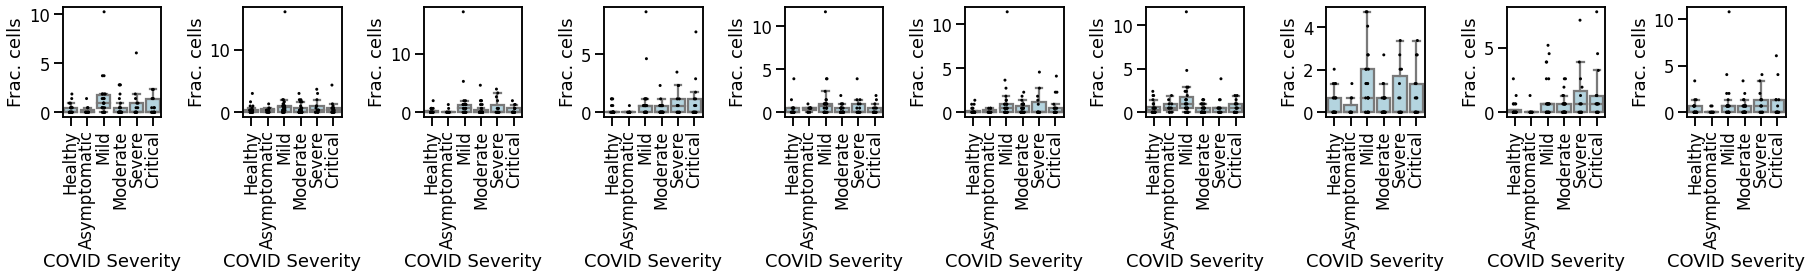

In [23]:
## Sanity check it's not just one donor
n = 10
with rc_context({'figure.figsize':[25,4]}):
    for ix,i in enumerate(np.random.choice(nhood_ixs, n)):
        plt.subplot(1,n,int(ix)+1);
        plot_nhood_counts_by_severity(nhood_adata, i, normalize=True);
    plt.tight_layout()

### Transitional state analysis 

... storing 'nhood_groups' as categorical


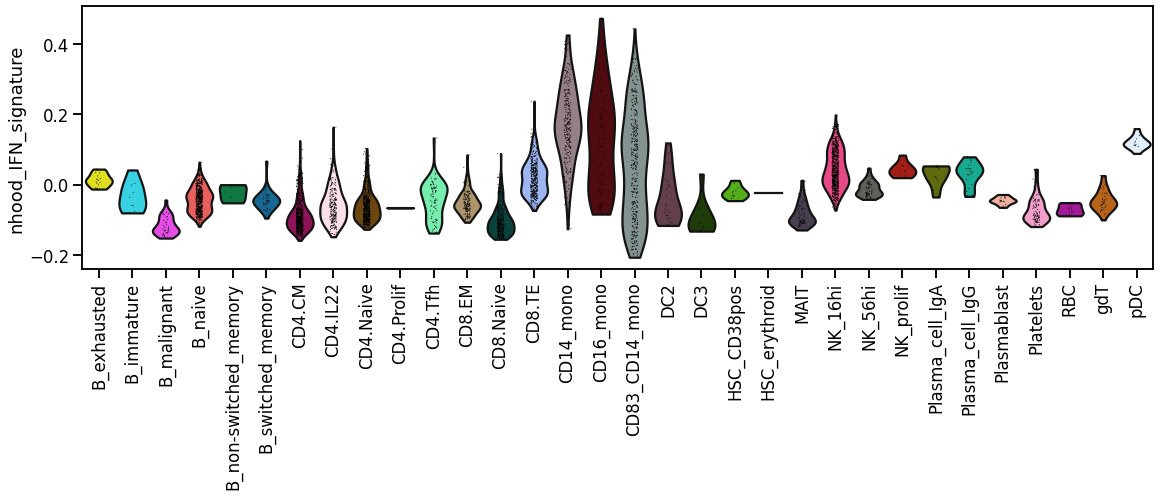

In [37]:
## Define transitional states for each cell type
with rc_context({'figure.figsize':[15,5]}):
    sc.pl.violin(nhood_adata, ['nhood_IFN_signature'], groupby='nhood_annotation', rotation=90)

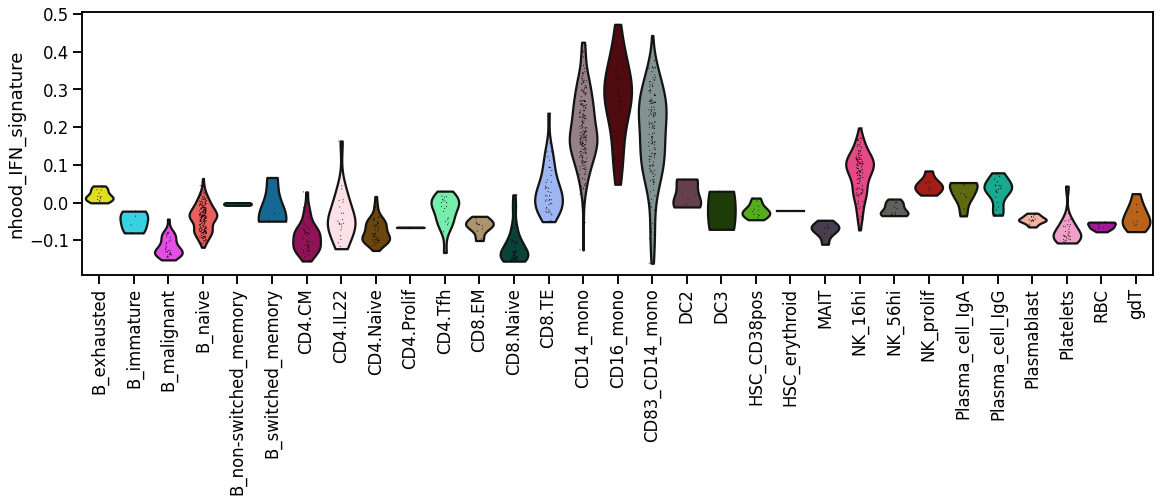

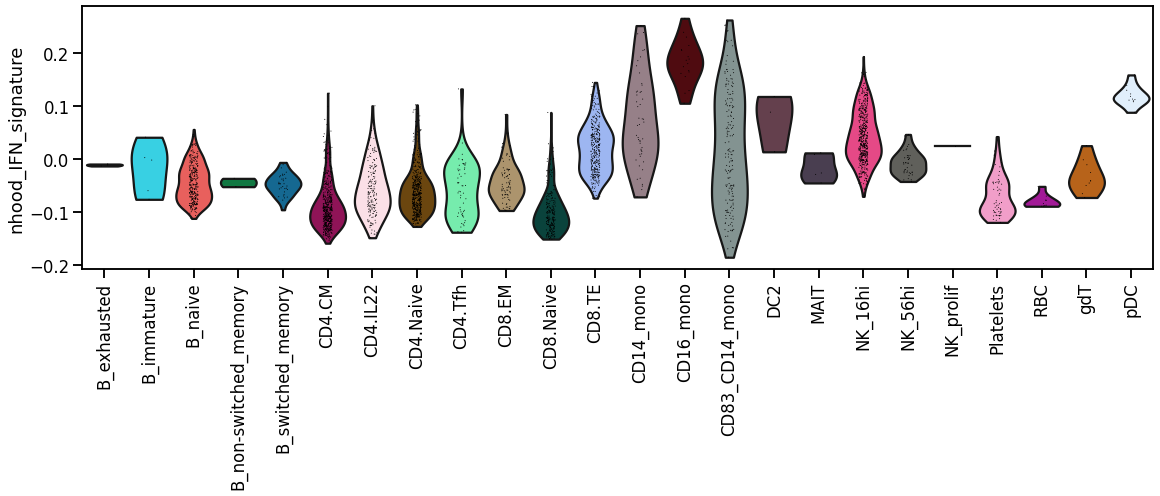

In [38]:
## Take nhoods enriched in COVID
signif_nhood = (nhood_adata.obs[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0
enr_nhood = (nhood_adata.obs[[f'logFC_{sev}' for sev in order_severity[1:]]] > 0).sum(1) > 0
with rc_context({'figure.figsize':[15,5]}):
    sc.pl.violin(nhood_adata[signif_nhood & enr_nhood], ['nhood_IFN_signature'], groupby='nhood_annotation', rotation=90)
    sc.pl.violin(nhood_adata[~signif_nhood], ['nhood_IFN_signature'], groupby='nhood_annotation', rotation=90);

In [44]:
fdr_cols = [f'SpatialFDR_{sev}' for sev in order_severity[1:]]
lfc_cols = [f'logFC_{sev}' for sev in order_severity[1:]]
pl_df = nhood_adata.obs[lfc_cols + fdr_cols + ['nhood_annotation', 'nhood_IFN_signature']]
lfc_df = pd.DataFrame()
for s in order_severity[1:]:
    lfc_sev_df = nhood_adata.obs[[f'logFC_{s}', f'SpatialFDR_{s}', 'nhood_annotation', 'nhood_IFN_signature']]
    lfc_sev_df.columns = [f'logFC', 'SpatialFDR', 'nhood_annotation', 'nhood_IFN_signature']
    lfc_sev_df['Severity'] = s
    lfc_df = pd.concat([lfc_df, lfc_sev_df], 0)
    
lfc_df['anno_group'] = [anno_group_rev[x] for x in lfc_df['nhood_annotation']]
lfc_df

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,logFC,SpatialFDR,nhood_annotation,nhood_IFN_signature,Severity,anno_group
0,0.157223,0.973210,NK_16hi,-0.002200,Asymptomatic,NK
1,-0.617565,0.826834,CD8.Naive,-0.065815,Asymptomatic,CD8 T
2,-0.147530,0.977665,B_naive,-0.075459,Asymptomatic,B cells
3,-0.341551,0.942384,CD4.CM,-0.067536,Asymptomatic,CD4 T
4,-0.511469,0.876407,CD4.CM,-0.140777,Asymptomatic,CD4 T
...,...,...,...,...,...,...
4784,0.107893,0.558459,CD8.TE,-0.005379,Critical,CD8 T
4785,-0.141068,0.350666,CD4.CM,-0.071640,Critical,CD4 T
4786,-0.270063,0.065422,gdT,-0.049021,Critical,unconv T
4787,-0.074788,0.692801,NK_16hi,0.034771,Critical,NK


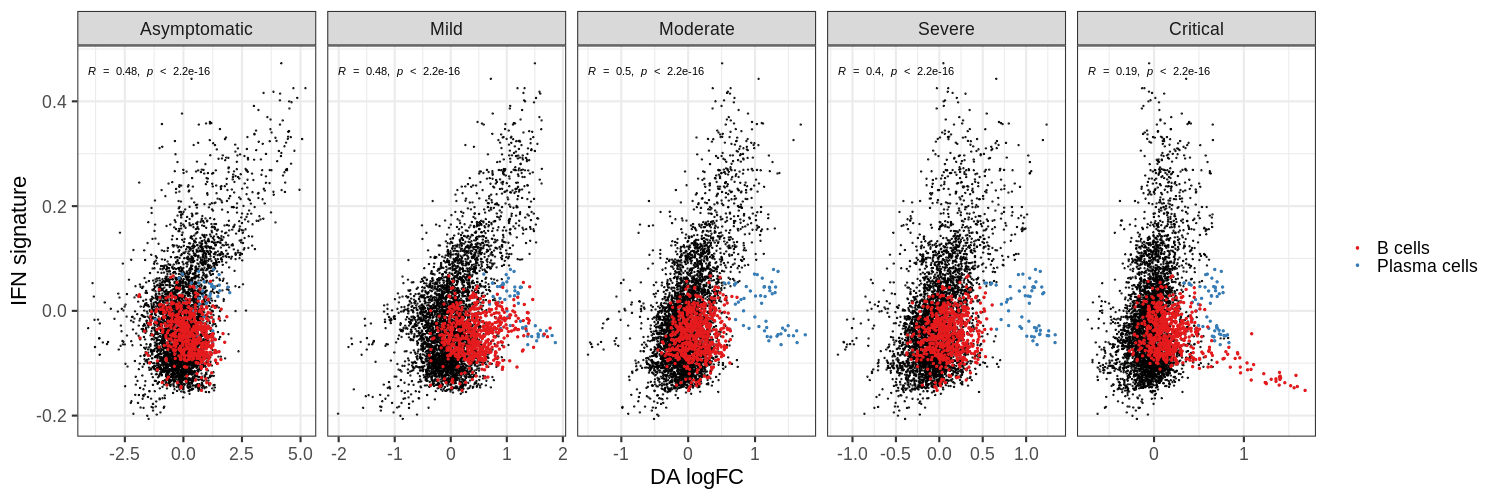

In [45]:
%%R -i lfc_df -i fdr_cols -i lfc_cols -w 1500 -h 500 -i order_severity
lfc_df %>%
# pivot_longer(cols=-c( nhood_annotation, anno_group, nhood_IFN_signature), names_to='Severity', values_to='logFC') %>%
# filter(str_detect(Severity, 'logFC_'))  %>%
# mutate(Severity = str_remove(Severity, 'logFC_')) %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
ggplot(aes(logFC, nhood_IFN_signature)) +
geom_point(size=0.5, alpha=0.8) +
geom_point(data = . %>% filter(anno_group=="plasma"), aes(color='Plasma cells'), size=0.9, alpha=1) +
# geom_point(data = . %>% filter(anno_group=="CD8 T"), aes(color='CD8+T'), size=0.9, alpha=1) +
geom_point(data = . %>% filter(anno_group=="B cells"), aes(color='B cells'), size=0.9, alpha=1) +
facet_grid(.~Severity, scales='free_x') +
scale_color_brewer(palette='Set1', name='') +
theme_bw(base_size=22) +
ylab("IFN signature") + xlab("DA logFC") +
ggpubr::stat_cor()

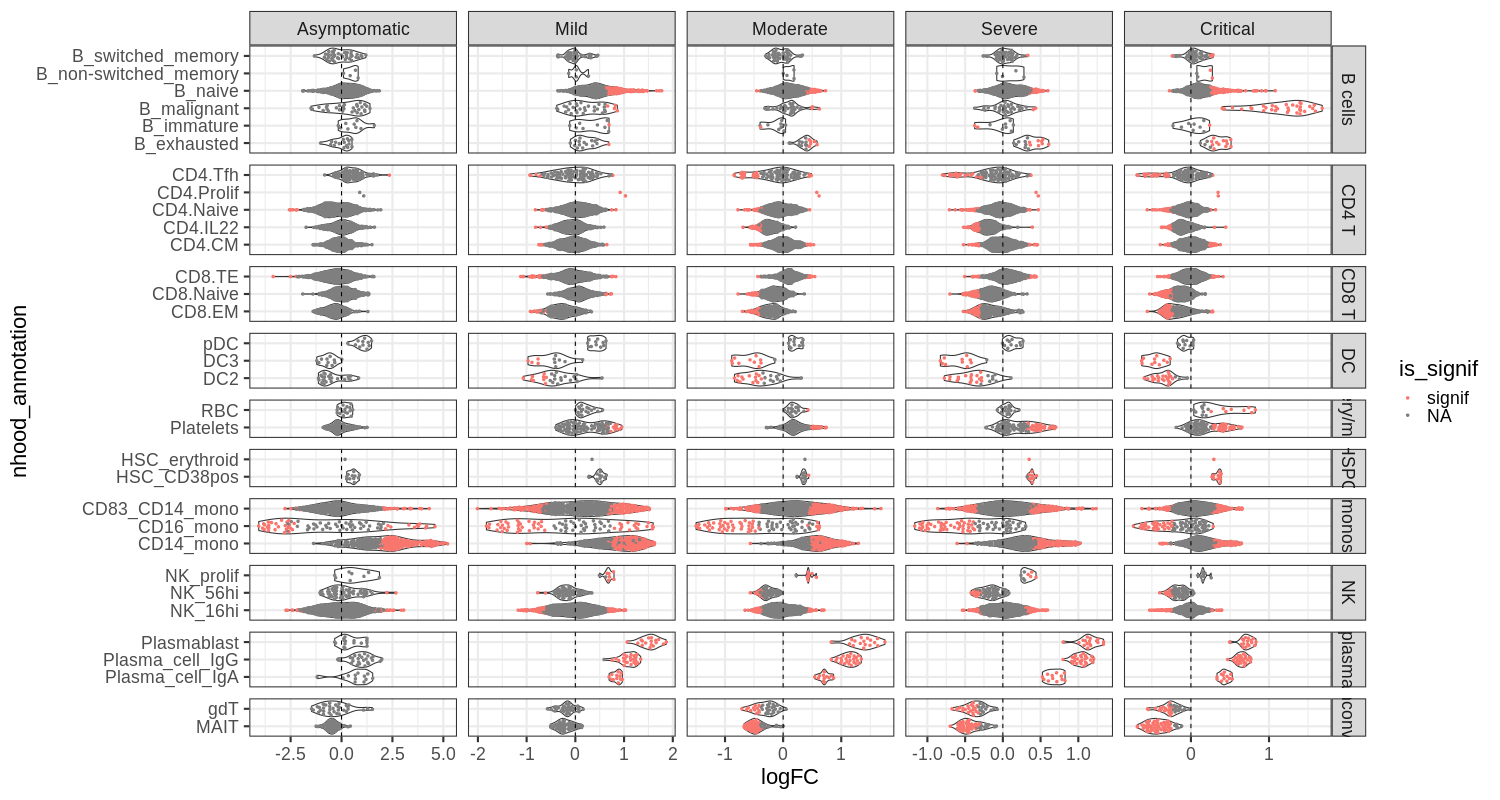

In [47]:
%%R -i lfc_df -i fdr_cols -i lfc_cols -w 1500 -h 800 -i order_severity
lfc_df %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(anno_group) %>%
mutate(scaled_IFN_signature = scale(nhood_IFN_signature)) %>%
arrange(scaled_IFN_signature) %>%
ungroup() %>%
mutate(is_signif = ifelse(SpatialFDR < 0.1, 'signif', NA)) %>%
ggplot(aes(nhood_annotation, y=logFC)) +
geom_violin(scale='width') +
ggbeeswarm::geom_quasirandom(aes(color=is_signif), size=1) +
coord_flip() +
facet_grid(anno_group~Severity, scales='free', space='free_y' ) +
theme_bw(base_size=22) +
# scale_color_viridis_c() +
geom_hline(yintercept=0, linetype=2)

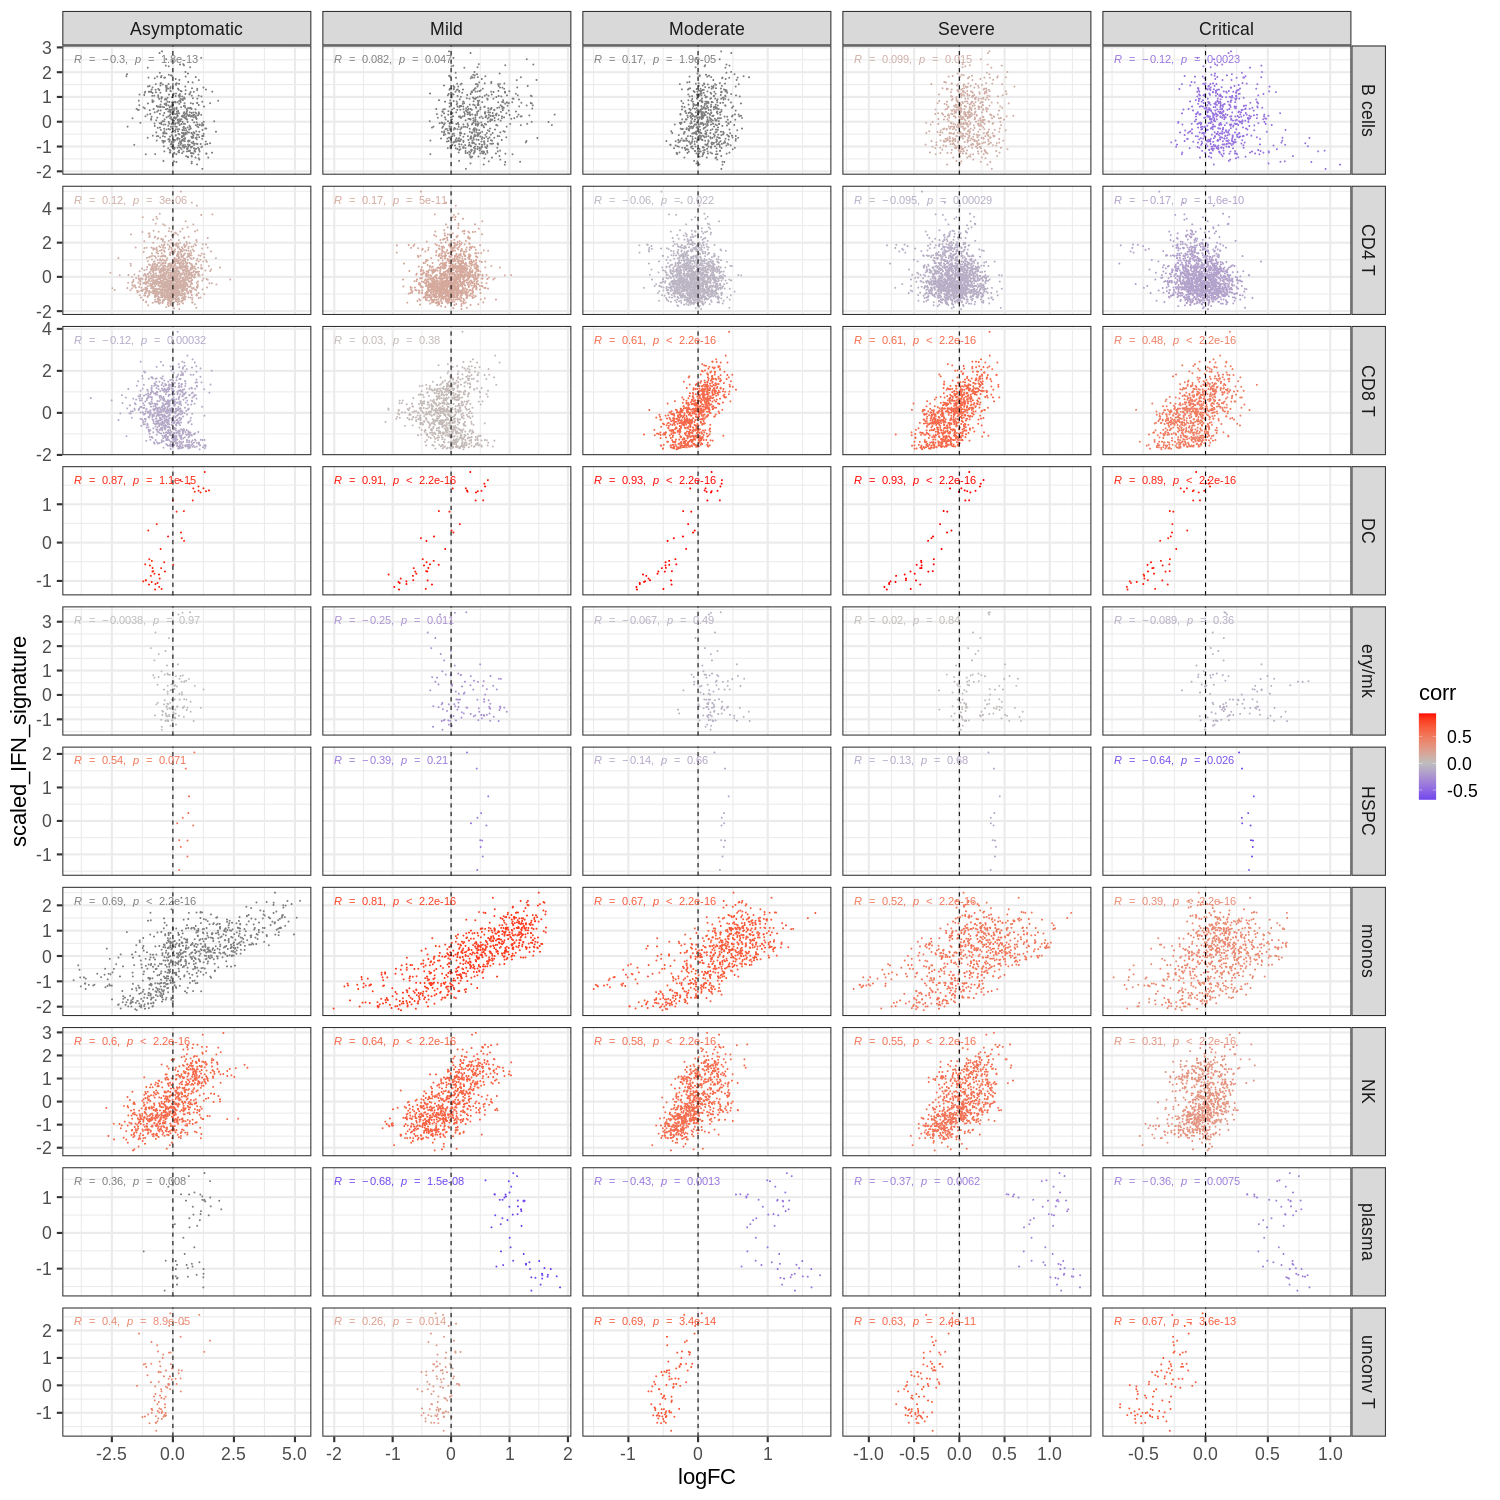

In [48]:
%%R -w 1500 -h 1500 -i order_severity
lfc_df %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(anno_group) %>%
mutate(scaled_IFN_signature = scale(nhood_IFN_signature)) %>%
arrange(scaled_IFN_signature) %>%
ungroup() %>%
group_by(anno_group, Severity) %>%
mutate(corr = cor(scaled_IFN_signature, logFC)) %>%
ungroup() %>%
filter(nhood_annotation != 'B_malignant') %>%
ggplot(aes(y=scaled_IFN_signature, x=logFC,color=corr)) +
geom_point(size=0.3) +
facet_grid(anno_group~Severity, scales='free') +
theme_bw(base_size=22) +
scale_color_gradient2(mid='grey', high='red', low='blue') +
geom_vline(xintercept=0, linetype=2) +
ggpubr::stat_cor()

`summarise()` has grouped output by 'anno_group'. You can override using the `.groups` argument.


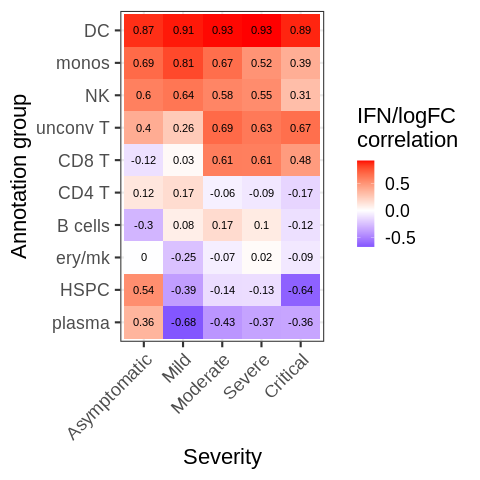

In [49]:
%%R
lfc_df %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
filter(nhood_annotation != 'B_malignant') %>%
group_by(anno_group) %>%
mutate(scaled_IFN_signature = scale(nhood_IFN_signature)) %>%
arrange(scaled_IFN_signature) %>%
ungroup() %>%
group_by(anno_group, Severity) %>%
summarise(corr = cor(scaled_IFN_signature, logFC, use="complete.obs")) %>%
ungroup() %>%
group_by(anno_group) %>%
mutate(mean_corr = mean(corr)) %>%
ungroup() %>%
arrange(mean_corr) %>%
mutate(anno_group = factor(anno_group, levels=unique(anno_group))) %>%
ggplot(aes(y=anno_group, x=Severity, fill=corr)) +
geom_tile() +
geom_text( aes(label=round(corr, 2))) +
theme_bw(base_size=22) +
ylab('Annotation group') +
scale_fill_gradient2(mid='white', high='red', low='blue', name='IFN/logFC\ncorrelation')  +
theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1))


- For high IFN cell types (e.g. monos, NK cells, DCs), the correlation falls in advanced stages of disease. Possibly this is due to the ifn signal going down, so low ifn cell states become more abundant
- Opposite in CD8 and unconventional T cells: low IFN CD8+T cells enriched in asymptomatic and mild cases

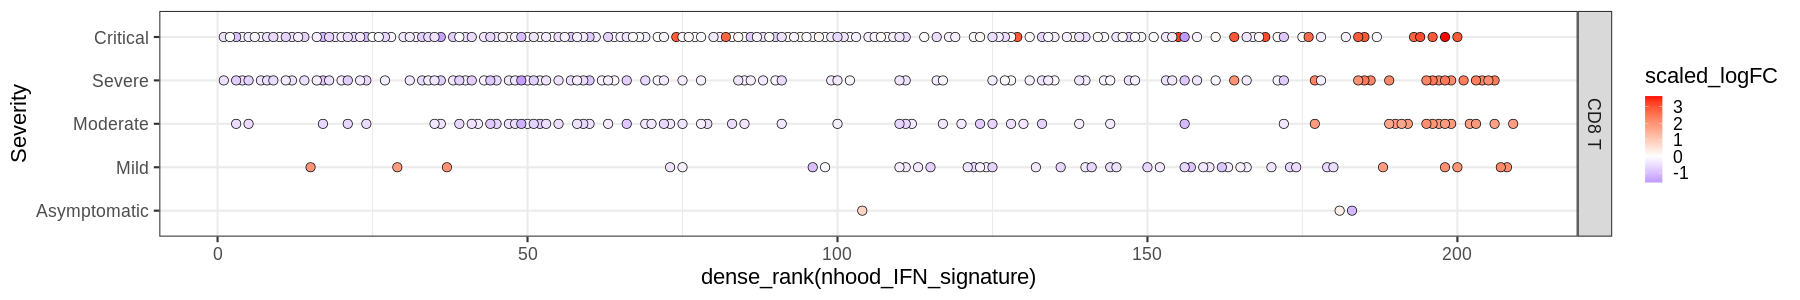

In [50]:
%%R -w 1800 -h 300 -i lfc_df
lfc_df %>%
filter(anno_group == 'CD8 T') %>%
filter(SpatialFDR < 0.1) %>%
# mutate(Severity = str_remove(Severity, 'logFC_')) %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(Severity) %>%
mutate(scaled_logFC = scale(logFC)) %>%
ggplot(aes(x=dense_rank(nhood_IFN_signature), y=Severity, fill=scaled_logFC)) +
# geom_tile() +
geom_point(size=4, pch=21) +
facet_grid(anno_group~., scales='free', space='free') +
theme_bw(base_size=22) +
scale_color_gradient2(mid='white', high='red', low='blue') +
scale_fill_gradient2(mid='white', high='red', low='blue') 

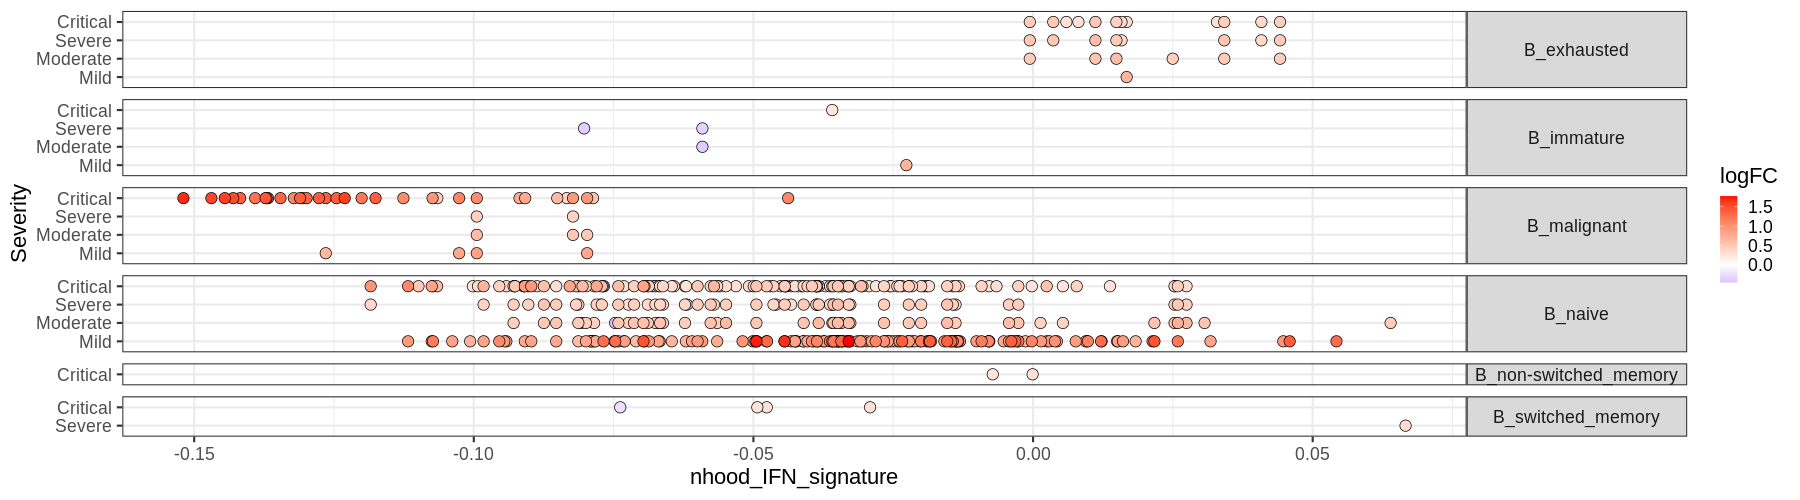

In [718]:
%%R -w 1800 -h 500 -i lfc_df
lfc_df %>%
filter(anno_group == 'B cells') %>%
filter((SpatialFDR < 0.1 )) %>%
# mutate(Severity = str_remove(Severity, 'logFC_')) %>%
mutate(Severity = factor(Severity, levels=unlist(order_severity))) %>%
group_by(Severity) %>%
mutate(scaled_logFC = scale(logFC)) %>%
arrange(scaled_logFC) %>%
ggplot(aes(x=nhood_IFN_signature, y=Severity, fill=logFC)) +
# geom_tile() +
geom_point(size=5, pch=21) +
facet_grid(nhood_annotation~., scales='free', space='free') +
theme_bw(base_size=22) +
scale_color_gradient2(mid='white', high='red', low='blue', midpoint=0) +
scale_fill_gradient2(mid='white', high='red', low='blue', midpoint=0) +
theme(strip.text.y=element_text(angle=0))

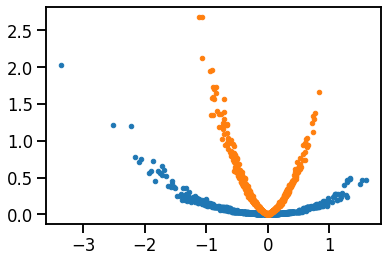

In [677]:
df = nhood_adata.obs[['logFC_Asymptomatic', 'logFC_Mild', 'SpatialFDR_Asymptomatic', 'SpatialFDR_Mild', 'nhood_annotation', 'nhood_IFN_signature']]
df = df[df.nhood_annotation.str.startswith("CD8.")].sort_values('nhood_IFN_signature')
df[(df.SpatialFDR_Asymptomatic < 0.1) | (df.SpatialFDR_Mild < 0.1)]
# plt.plot(df.nhood_IFN_signature,-np.log10(df.SpatialFDR_Mild), '.')
plt.plot(df.logFC_Asymptomatic,-np.log10(df.SpatialFDR_Asymptomatic), '.')
plt.plot(df.logFC_Mild,-np.log10(df.SpatialFDR_Mild), '.')

## DE analysis 

In [51]:
import diff2atlas

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args)
    de_res_df = pd.DataFrame(de_res_df)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    return(de_res_df)

def find_nhood_group_markers(
    adata, 
    test_group: str,
    ctrl_group: str,
    confounders_obs = None,
    nhood_group_obs: str = 'nhood_groups',
    min_n_nhoods: int = 3,
    pbulk_use_layer: str = None,
    n_hvgs: int = 5
    ):
    '''
    Find genes differentially expressed between cells in 2 groups of neighbourhoods
    
    Params:
    -------
    - adata: AnnData object storing nhood info in adata.uns['nhood_adata']
    - design: design formula for the test, passed to glmGamPoi
    - test_group: which neighbourhood group is the test group?
    - ctrl_group: which neighbourhood group is the reference group?
    - nhood_group_obs: the column in adata.uns['nhood_adata'] storing the neighbourhood group information
    - min_n_nhoods: cells are assigned to a neighbourhood group only if it belongs to at least min_n_nhoods neighbourhoods in the group
    - pbulk_use_layer: layer storing counts (if None, adata.X is used) 
    - n_hvgs: how many HVGS to use for the DE test (the more you use, the longer it takes)
    
    Returns:
    --------
    pd.DataFrame storing DE test results
    '''

    ## Find cells in nhoods of interest
    groups = adata.uns['nhood_adata'].obs[nhood_group_obs].dropna().unique()
    for g in groups:
        nhoods_oi = adata.uns['nhood_adata'].obs_names[adata.uns['nhood_adata'].obs[nhood_group_obs] == g]
        diff2atlas.utils.get_cells_in_nhoods(adata, nhoods_oi)
        adata.obs[f'in_nhoods_{g}'] = adata.obs['in_nhoods'].copy()

    ## Find most representative group (cell belongs to mostly to neighbourhoods of that group)
    adata.obs['nhood_groups'] = np.nan
    adata.obs['nhood_groups'] = adata.obs[[f'in_nhoods_{g}' for g in groups]].idxmax(1)
    ## Keep only if cell is in at least min_n_nhoods nhoods of the same group
    adata.obs.loc[~(adata.obs[[f'in_nhoods_{g}' for g in groups]] > min_n_nhoods).any(1), 'nhood_groups'] = np.nan 

    ## Make pseudobulk adata for cells if different nhood groups and samples
    sdata = adata[~adata.obs['nhood_groups'].isna()].copy()
    sdata.X = sdata.layers['counts'].copy()
    if confounders_obs is None:
        design = '~ nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[adata.uns['nhood_adata'].uns['sample_col'], 'nhood_groups'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)
    else:
        if isinstance(confounders_obs, str):
            confounder_obs = [confounders_obs]
        design = "~ " + ' + '.join(confounders_obs) + ' + nhood_groups'
        pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[nhood_adata.uns['sample_col'], 'nhood_groups'] + confounders_obs, 
            min_ncells=1, 
            use_layer=pbulk_use_layer)

    
    de_results = run_glmGamPoi_DE(pbulk_sdata, design=design, 
                           ref_level = f'in_nhoods_{ctrl_group}', 
                           contrast = f'nhood_groupsin_nhoods_{test_group}', 
                           n_hvgs=n_hvgs)
    return(de_results)

### B naive nhood groups

In [53]:
nhood_adata

AnnData object with n_obs × n_vars = 4789 × 130
    obs: 'index_cell', 'kth_distance', 'nhood_annotation', 'nhood_annotation_frac', 'SpatialFDR', 'nhood_IFN_signature', 'logFC_Asymptomatic', 'SpatialFDR_Asymptomatic', 'logFC_Mild', 'SpatialFDR_Mild', 'logFC_Moderate', 'SpatialFDR_Moderate', 'logFC_Severe', 'SpatialFDR_Severe', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'logFC_Critical', 'SpatialFDR_Critical', 'nhood_groups'
    var: 'severity_cont', 'Site', 'sample_id'
    uns: 'annotation_labels', 'sample_col', 'nhood_annotation_colors'
    obsm: 'frac_annotation'

In [56]:
logFC_df = nhood_adata.obs[ [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
logFC_df = logFC_df.dropna()
logFC_df['nhood_id'] = logFC_df.index.copy()
nhood_order = logFC_df.sort_values('logFC_Critical')['nhood_id'].values

FDR_df = nhood_adata.obs[ [f'SpatialFDR_{sev}' for sev in order_severity[1:]] + ['nhood_annotation', "nhood_IFN_signature"]]
FDR_df = FDR_df.dropna()
FDR_df['nhood_id'] = FDR_df.index.copy()

## scale logFC for each test
lfc_df = logFC_df[[f'logFC_{sev}' for sev in order_severity[1:]]]
scaled_lfc_df = lfc_df/lfc_df.std(0)
logFC_df.loc[:,[f'logFC_{sev}' for sev in order_severity[1:]]] = scaled_lfc_df

## Select nhoods with at least one signif DA
signif_nhoods = (FDR_df[[f'SpatialFDR_{sev}' for sev in order_severity[1:]]] < 0.1).sum(1) > 0
lfc_df = logFC_df.loc[signif_nhoods, [f'logFC_{sev}' for sev in order_severity[1:]] + ['nhood_id']]

lfc_df = lfc_df.loc[order_index]

## Make cell type identity heatmap (1/0)
dummy_anno_df = logFC_df[['nhood_annotation', 'nhood_id']].loc[order_index]
dummy_anno_df['anno_group'] = [anno_group_rev[x] for x in dummy_anno_df['nhood_annotation']]
anno_group_order = list(anno_group_order)

lfc_df = pd.merge(lfc_df, dummy_anno_df)
lfc_df

,logFC_Asymptomatic,logFC_Mild,logFC_Moderate,logFC_Severe,logFC_Critical,nhood_id,nhood_annotation,anno_group
0,-0.643331,1.365259,0.908265,0.785217,6.096818,1424,B_malignant,B cells
1,0.771672,1.257700,0.840087,0.711407,6.154769,1431,B_malignant,B cells
2,0.142558,0.930505,0.703720,0.465286,6.129770,1452,B_malignant,B cells
3,1.135137,0.333982,0.499920,0.027060,5.458437,1429,B_malignant,B cells
4,0.576815,0.388620,0.049313,-0.373632,5.335318,1456,B_malignant,B cells
...,...,...,...,...,...,...,...,...
1628,-1.700730,-1.535745,-1.412362,-1.326208,-0.695261,3909,CD83_CD14_mono,monos
1629,-1.485686,-1.767079,-1.491987,-1.405349,-0.834786,4111,CD83_CD14_mono,monos
1630,-1.543066,-1.853977,-1.295473,-1.702468,-1.049069,4285,CD83_CD14_mono,monos
1631,-1.699038,-2.071097,-1.375262,-1.318493,-0.363197,3652,NK_16hi,NK


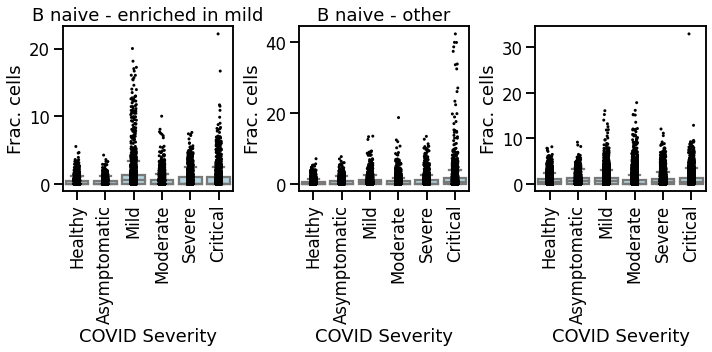

In [57]:
### Pick neighbourhoods of interest
nhoods_mild = lfc_df_bnaive['nhood_id'][lfc_df_bnaive['nhood_id'].isin(nhood_ixs)].values
nhoods_crit = lfc_df_bnaive['nhood_id'][~lfc_df_bnaive['nhood_id'].isin(nhood_ixs)].values
nhoods_other = nhood_adata.obs_names[(nhood_adata.obs.nhood_annotation == 'B_naive') & (~nhood_adata.obs_names.isin(lfc_df.nhood_id))]

with rc_context({'figure.figsize':[10,5]}):
    plt.subplot(1,3,1);
    plot_nhood_counts_by_severity(nhood_adata, nhoods_mild, normalize=True);
    plt.title("B naive - enriched in mild");
    plt.subplot(1,3,2);
    plot_nhood_counts_by_severity(nhood_adata, nhoods_crit, normalize=True);
    plt.title("B naive - other")
    plt.subplot(1,3,3);
    plot_nhood_counts_by_severity(nhood_adata, nhoods_other, normalize=True);
    plt.tight_layout()

nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs['nhood_groups'] = np.nan
nhood_adata.obs.loc[nhoods_mild, 'nhood_groups'] = 'mild_enr'
nhood_adata.obs.loc[nhoods_crit, 'nhood_groups'] = 'critical_enr'
nhood_adata.obs.loc[nhoods_other, 'nhood_groups'] = 'other'
adata.uns['nhood_adata'] = nhood_adata.copy()

In [58]:
## Run DE testing
DE_Bnaive_critical = find_nhood_group_markers(
    adata, 
    test_group='critical_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

DE_Bnaive_mild = find_nhood_group_markers(
    adata, 
    test_group='mild_enr', 
    ctrl_group='other', 
    confounders_obs=['Site'],
    n_hvgs = 7500
    )

In [60]:
## Save 
DE_Bnaive_critical['contrast'] = 'critical_enr-other'
DE_Bnaive_mild['contrast'] = 'mild_enr-other'
DE_Bnaive = pd.concat([DE_Bnaive_mild, DE_Bnaive_critical])
DE_Bnaive.to_csv(resdir + 'DEresults_BnaiveNhoods.csv')

In [68]:
DE_Bnaive

,pval,adj_pval,f_statistic,df1,df2,lfc,gene_name,contrast
gene_name,,,,,,,,
EEF1G,9.965075e-01,9.998798e-01,0.000019,1,361.116601,-0.000358,EEF1G,mild_enr-other
RPS4Y1,6.599756e-01,8.455847e-01,0.193873,1,361.116601,0.150871,RPS4Y1,mild_enr-other
MTRNR2L8,5.265980e-01,7.672996e-01,0.401731,1,361.116601,0.356794,MTRNR2L8,mild_enr-other
FOS,1.651514e-52,3.217701e-49,327.054442,1,361.116601,-2.634922,FOS,mild_enr-other
HBB,6.247273e-02,2.560681e-01,3.492073,1,361.116601,-1.142329,HBB,mild_enr-other
...,...,...,...,...,...,...,...,...
SOX13,5.265625e-01,8.467202e-01,0.401800,1,361.116601,-21.811663,SOX13,critical_enr-other
RFPL1S,5.205077e-01,8.454445e-01,0.413696,1,361.116601,-21.755911,RFPL1S,critical_enr-other
TMIGD3,7.422053e-02,4.253127e-01,3.205681,1,361.116601,26.569961,TMIGD3,critical_enr-other


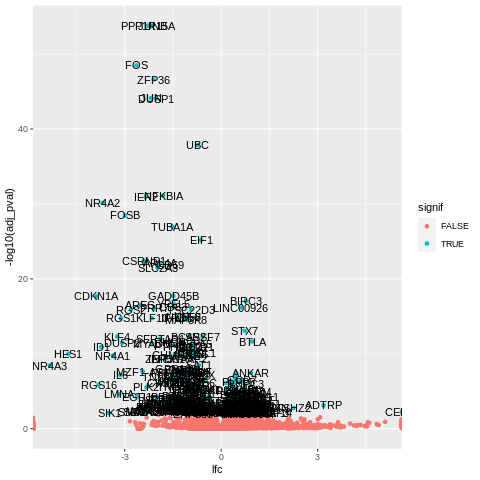

In [69]:
%%R -i DE_Bnaive
max_lfc = 15
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    filter(contrast == 'mild_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.5), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

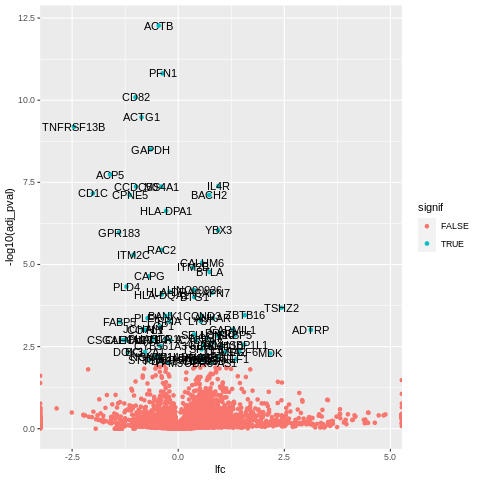

In [71]:
%%R -i DE_Bnaive
max_lfc = 15
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    filter(contrast == 'critical_enr-other') %>%
    mutate(signif = adj_pval < 0.01) %>%
    mutate(label = ifelse(signif & (abs(lfc) > 0.2), as.character(gene_name), NA)) %>%
    ggplot(aes(lfc, -log10(adj_pval))) + 
    geom_point(aes(color=signif)) +
    geom_text(aes(label=label))

In [148]:
%%R -w 800 -h 800
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_critical < 0.1) & (adj_pval_mild < 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

crit_specific_pl <- DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_critical < 0.1) & (adj_pval_mild > 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)
    
mild_specific_pl <- DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse((adj_pval_critical > 0.1) & (adj_pval_mild <= 0.1), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

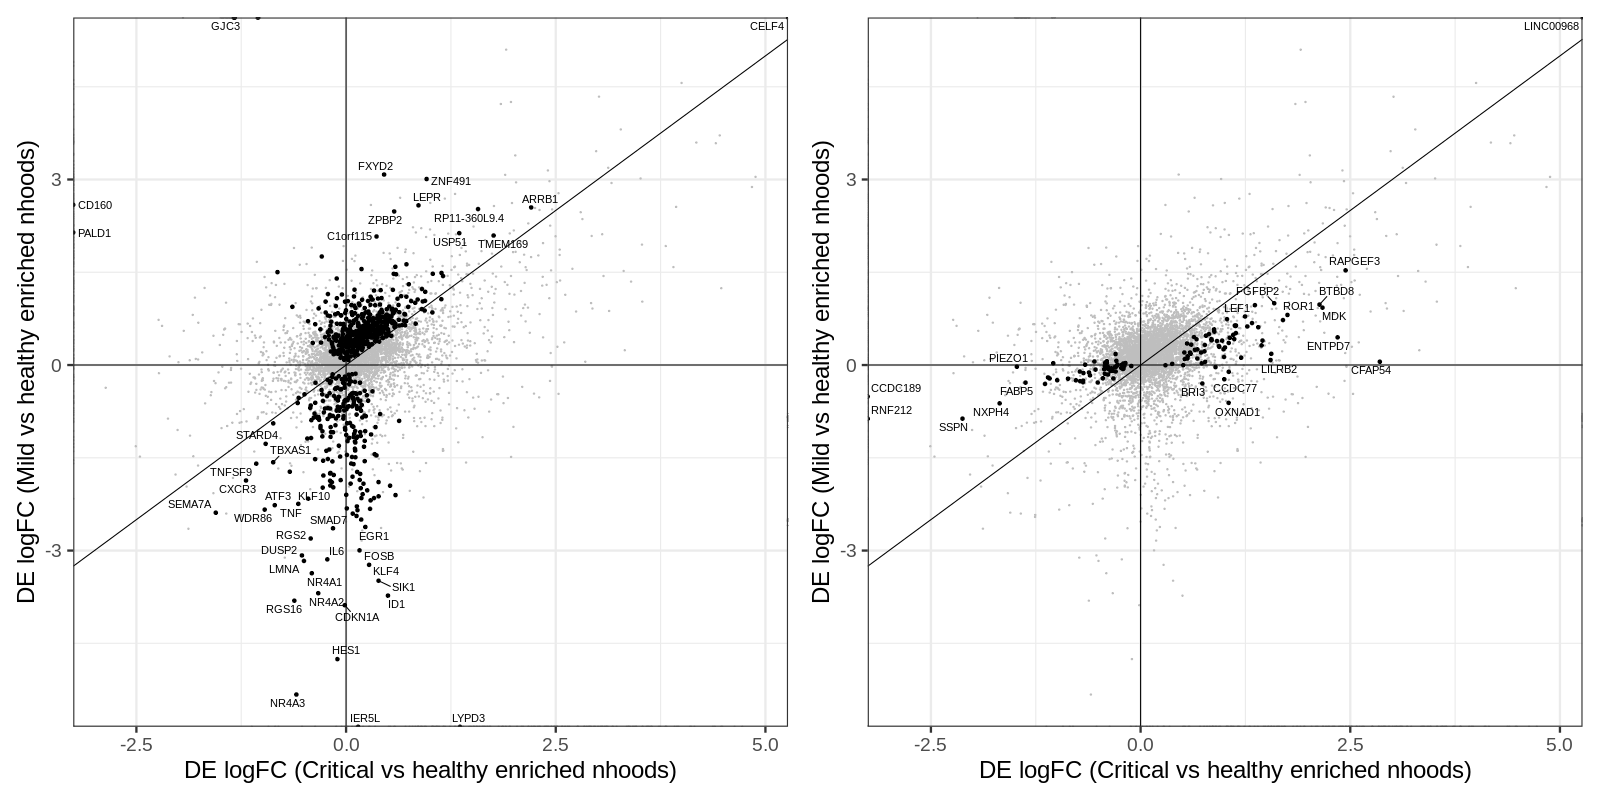

In [150]:
%%R -w 1600 -h 800
mild_specific_pl + crit_specific_pl

### Enrichment analysis

In [134]:
import gseapy as gp
from gseapy.plot import barplot, dotplot

def run_enrichr(DE_results, alpha=0.1, 
                min_lfc = 0,
                outdir = resdir + 'enrichr/Bnaive/', gene_sets=['MSigDB_Hallmark_2020']):
    names = gp.get_library_name()

    up_genes = DE_results[(DE_results.adj_pval < alpha) & (DE_results.lfc > min_lfc)].index
    down_genes = DE_results[(DE_results.adj_pval < alpha) & (DE_results.lfc < - min_lfc)].index

    bg_genes = DE_Bnaive.index.unique()

    enr_up = gp.enrichr(gene_list=up_genes.tolist(),
                             gene_sets=gene_sets,
                             organism='Human', 
                             background=bg_genes.tolist(),
                             outdir=outdir + '/up_genes/',
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            ).results
    enr_down = gp.enrichr(gene_list=down_genes.tolist(),
                             gene_sets=gene_sets,
                             organism='Human', 
                             background=bg_genes.tolist(),
                             outdir=outdir + '/down_genes/',
                             cutoff=0.5 # test dataset, use lower value from range(0,1)
                            ).results
    return(enr_up, enr_down)
    

In [180]:
signif_crit = DE_Bnaive.gene_name[(DE_Bnaive.adj_pval < 0.1) & (DE_Bnaive.contrast == 'critical_enr-other')].values
signif_mild = DE_Bnaive.gene_name[(DE_Bnaive.adj_pval < 0.1) & (DE_Bnaive.contrast == 'mild_enr-other')].values

signif_both = np.intersect1d(signif_crit, signif_mild)
signif_crit_only = np.setdiff1d(signif_crit, signif_mild)
signif_mild_only = np.setdiff1d(signif_mild, signif_crit)

In [186]:
enr_mild_up, enr_mild_down = run_enrichr(DE_Bnaive[DE_Bnaive.contrast == 'mild_enr-other'].loc[signif_mild_only], 
                                         min_lfc= 0.2,
                                         outdir = resdir + 'enrichr/Bnaive_mild/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])
enr_crit_up, enr_crit_down = run_enrichr(DE_Bnaive[DE_Bnaive.contrast == 'critical_enr-other'].loc[signif_crit_only], 
                                         min_lfc= 0.2,
                                         outdir = resdir + 'enrichr/Bnaive_critical/',
                                        gene_sets=['GO_Biological_Process_2021', 'MSigDB_Hallmark_2020'])

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:0345b0e84d0a17b17e29118124bfaebc
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:03db2ec95affb4a66e741be521564ada
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:1834bb7498c8424ab1ce5548f93d39e6
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:116b9d34cd68b5dc0a605c1f6ae70ff8
Done.

Connecting to Enrichr Server to get latest library names
Analysis name: , Enrichr Library: GO_Biological_Process_2021
Save file of enrichment results: Job Id:db8abf9f662df9ed0e796b121404d4fe
Done.

Analysis name: , Enrichr Library: MSigDB_Hallmark_2020
Save file of enrichment results: Job Id:670a95409e41db8b70fea341ae7d7ae7
Done.

C

In [182]:
enr_crit_up[enr_crit_up['Adjusted P-value'] < 0.1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of angiogenesis (GO:0045766),5/116,0.000044,0.024519,0,0,14.401337,144.586398,BTG1;MDK;GAB1;HIPK1;RAPGEF3
1,GO_Biological_Process_2021,positive regulation of vasculature development...,4/102,0.000382,0.075476,0,0,12.850664,101.138092,BTG1;GAB1;HIPK1;RAPGEF3
2,GO_Biological_Process_2021,positive regulation of T cell differentiation ...,3/43,0.000403,0.075476,0,0,23.312109,182.226730,MDK;LEF1;LILRB2
3,GO_Biological_Process_2021,regulation of angiogenesis (GO:0045765),5/203,0.000594,0.083523,0,0,8.038042,59.705333,BTG1;SERPINF1;GAB1;HIPK1;RAPGEF3


In [183]:
enr_crit_down[enr_crit_down['Adjusted P-value'] < 0.1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cell projection organization (GO:0030030),4/30,0.000001,0.000529,0,0,61.292308,833.878682,PLEK;RAC2;CAPG;NCKAP1L
1,GO_Biological_Process_2021,platelet aggregation (GO:0070527),4/36,0.000003,0.000529,0,0,49.785000,639.823793,PLEK;CLIC1;PPIA;ACTG1
2,GO_Biological_Process_2021,cortical cytoskeleton organization (GO:0030865),4/41,0.000004,0.000529,0,0,43.046486,530.326914,PLEK;RAC2;NCKAP1L;LCP1
3,GO_Biological_Process_2021,neutrophil degranulation (GO:0043312),9/481,0.000005,0.000529,0,0,8.251695,100.591060,PLAC8;FABP5;NME2;COTL1;CTSH;NCKAP1L;CD68;DYNLL...
4,GO_Biological_Process_2021,neutrophil activation involved in immune respo...,9/485,0.000005,0.000529,0,0,8.180672,99.177495,PLAC8;FABP5;NME2;COTL1;CTSH;NCKAP1L;CD68;DYNLL...
...,...,...,...,...,...,...,...,...,...,...
183,GO_Biological_Process_2021,negative regulation of interleukin-17 producti...,1/11,0.029309,0.097126,0,0,37.615094,132.775624,NCKAP1L
184,GO_Biological_Process_2021,regulation of histone H3-K9 acetylation (GO:20...,1/11,0.029309,0.097126,0,0,37.615094,132.775624,SMARCB1
185,GO_Biological_Process_2021,cellular response to superoxide (GO:0071451),1/11,0.029309,0.097126,0,0,37.615094,132.775624,PRDX1
186,GO_Biological_Process_2021,T cell homeostasis (GO:0043029),1/11,0.029309,0.097126,0,0,37.615094,132.775624,NCKAP1L


In [184]:
enr_mild_up[enr_mild_up['Adjusted P-value'] < 0.1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,nuclear mRNA surveillance (GO:0071028),4/10,0.000043,0.048071,0,0,29.969349,301.115608,EXOSC7;PCID2;EXOSC10;XRN1
1,GO_Biological_Process_2021,maturation of 5.8S rRNA from tricistronic rRNA...,5/22,0.000096,0.048071,0,0,13.244782,122.485041,EXOSC7;EXOSC10;PES1;RRS1;EXOSC3
2,GO_Biological_Process_2021,cellular response to oxidative stress (GO:0034...,11/125,0.000099,0.048071,0,0,4.384264,40.430617,PRKAA1;PINK1;NCF1;GSTP1;PXN;AKT1;CYBB;MAPK1;PY...
3,GO_Biological_Process_2021,nuclear retention of pre-mRNA at the site of t...,3/5,0.000102,0.048071,0,0,67.290138,618.670538,PCID2;EXOSC10;EXOSC3
4,GO_Biological_Process_2021,regulation of B cell receptor signaling pathwa...,5/23,0.000121,0.048071,0,0,12.508321,112.834664,CD19;SLC39A10;STAP1;GCSAM;CD22
5,GO_Biological_Process_2021,tRNA surveillance (GO:0106354),3/6,0.000200,0.048071,0,0,44.857798,382.070635,EXOSC7;EXOSC10;EXOSC3
6,GO_Biological_Process_2021,negative regulation of ERAD pathway (GO:1904293),3/6,0.000200,0.048071,0,0,44.857798,382.070635,USP14;USP25;SVIP
7,GO_Biological_Process_2021,nuclear polyadenylation-dependent ncRNA catabo...,3/6,0.000200,0.048071,0,0,44.857798,382.070635,EXOSC7;EXOSC10;EXOSC3
8,GO_Biological_Process_2021,nuclear polyadenylation-dependent rRNA catabol...,3/6,0.000200,0.048071,0,0,44.857798,382.070635,EXOSC7;EXOSC10;EXOSC3
9,GO_Biological_Process_2021,nuclear polyadenylation-dependent tRNA catabol...,3/6,0.000200,0.048071,0,0,44.857798,382.070635,EXOSC7;EXOSC10;EXOSC3


In [185]:
enr_mild_down[enr_mild_down['Adjusted P-value'] < 0.1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of transcription by RNA po...,37/908,4.205757e-12,8.403103e-09,0,0,4.413709,115.615199,ARF4;CSRNP1;DDX3X;CITED2;TNF;UBC;EPC1;HES1;KAT...
1,GO_Biological_Process_2021,"positive regulation of transcription, DNA-temp...",39/1183,5.678675e-10,5.672997e-07,0,0,3.529735,75.144995,ARF4;CSRNP1;DDX3X;CITED2;TNF;SERTAD1;UBC;EPC1;...
2,GO_Biological_Process_2021,regulation of cell cycle (GO:0051726),18/296,4.894958e-09,3.260042e-06,0,0,6.282508,120.216174,TSPYL2;PPP1R15A;JUN;CDKN1A;JUND;GADD45B;DUSP1;...
3,GO_Biological_Process_2021,negative regulation of transcription by RNA po...,27/684,8.747523e-09,4.369388e-06,0,0,4.093322,75.949522,CITED2;ZBTB1;TNF;ZFP36;UBC;ZNF669;EPC1;HES1;SK...
4,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,53/2206,2.366304e-08,9.455750e-06,0,0,2.614128,45.902387,ARF4;CSRNP1;CDKN1A;DDX3X;CCNH;CITED2;TNF;ZFP36...
...,...,...,...,...,...,...,...,...,...,...
328,GO_Biological_Process_2021,positive regulation of response to endoplasmic...,2/18,1.627174e-02,9.881743e-02,0,0,11.385369,46.888654,DDIT3;PMAIP1
329,GO_Biological_Process_2021,cellular response to mechanical stimulus (GO:0...,3/49,1.648636e-02,9.891816e-02,0,0,5.958635,24.461520,PTGER4;IRF1;NFKB1
330,GO_Biological_Process_2021,regulation of interferon-beta production (GO:0...,3/49,1.648636e-02,9.891816e-02,0,0,5.958635,24.461520,DDX3X;IRF1;RELB
331,GO_Biological_Process_2021,response to hydrogen peroxide (GO:0042542),3/49,1.648636e-02,9.891816e-02,0,0,5.958635,24.461520,OSER1;IL6;TNFAIP3


In [143]:
pl_genes = enr_mild_up.iloc[5].Genes.split(';')

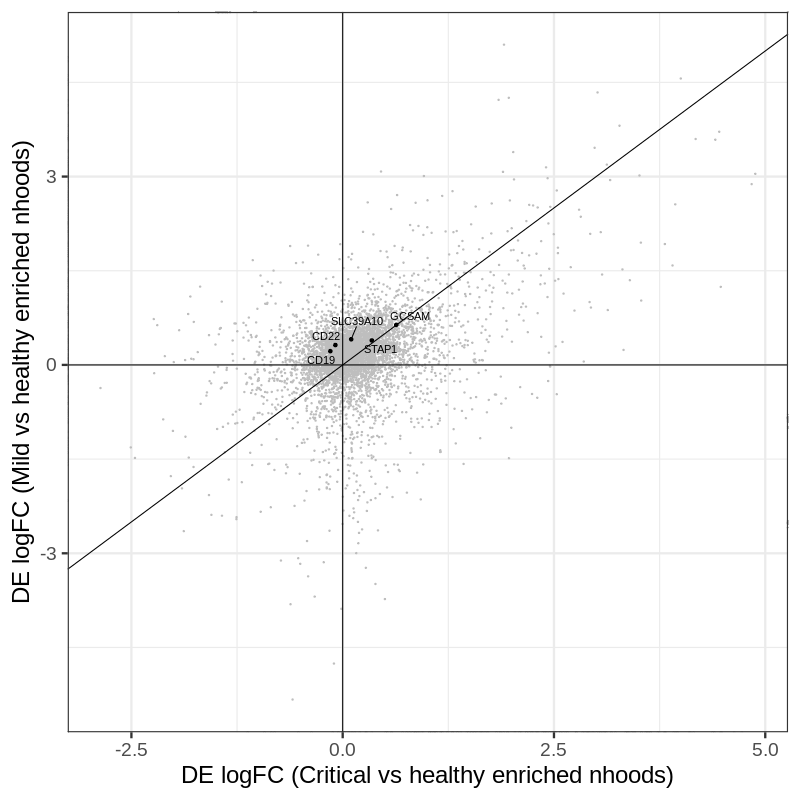

In [144]:
%%R -w 800 -h 800 -i pl_genes
DE_Bnaive$lfc <- ifelse(abs(DE_Bnaive$lfc) > max_lfc, sign(DE_Bnaive$lfc) * Inf, DE_Bnaive$lfc)
DE_Bnaive %>%
    mutate(contrast=str_remove(contrast, '_enr-other')) %>%
    pivot_wider(id_cols=gene_name, names_from='contrast', values_from=c('lfc', 'adj_pval')) %>%
    mutate(label = ifelse(as.character(gene_name) %in% unlist(pl_genes), 
                          as.character(gene_name), 
                          NA)) %>%
    ggplot(aes(lfc_critical, lfc_mild)) + geom_point(color='grey', size=0.5) +
    geom_point(data=. %>% filter(!is.na(label)), color='black') +
    ggrepel::geom_text_repel(aes(label=label)) +
    geom_abline() +
    geom_vline(xintercept=0)  + geom_hline(yintercept=0) +
    xlab('DE logFC (Critical vs healthy enriched nhoods)') +
    ylab('DE logFC (Mild vs healthy enriched nhoods)') +
    theme_bw(base_size=24)

---
---
---

In [27]:
%%R -i cell_count_df
dim(cell_count_df)

[1] 593836      6


Joining, by = c("nhood_id", "nhood_annotation", "nhood_IFN_signature", "max_severity")
Joining, by = c("nhood_id", "nhood_annotation", "nhood_IFN_signature", "max_severity")


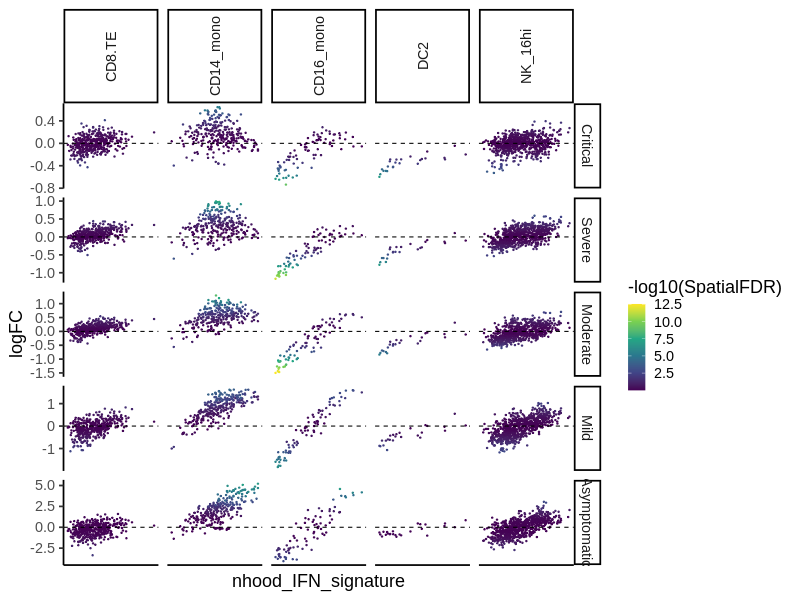

In [73]:
%%R -w 800 -h 600
min_max_scale <- function(x){
    x_scaled <- (x - min(x))/(max(x) - min(x))
    return(x_scaled)
}

keep_nhoods <- left_join(mutate(logFC_df, max_severity=str_remove(max_severity, "logFC_")),
          mutate(FDR_df, max_severity=str_remove(max_severity, "SpatialFDR_"))) %>%
    filter(nhood_annotation == 'CD16_mono' & logFC < -1) %>%
    pull(nhood_id) %>% unique()
    
# cell_count_df %>%
#     filter(nhood_id %in% keep_nhoods) %>%
#     ggplot(aes(as.factor(severity_cont), n_cells)) +
#     geom_boxplot(outlier.alpha=0) +
#     geom_jitter(size=0.1) 
    
left_join(mutate(logFC_df, max_severity=str_remove(max_severity, "logFC_")),
          mutate(FDR_df, max_severity=str_remove(max_severity, "SpatialFDR_"))) %>%
    mutate(max_severity=factor(max_severity, levels=order_severity)) %>%
    filter(nhood_annotation %in% c('NK_16hi', "CD8.TE", "CD14_mono", "CD16_mono", "DC2")) %>%
    group_by(max_severity) %>%
    mutate(scaled_logFC = scale(logFC)) %>%
    ungroup() %>%
    group_by(nhood_id) %>%
    mutate(mean_logFC = mean(scaled_logFC)) %>%
    mutate(cumsum = cumsum(sign(scaled_logFC))) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
#     mutate(nhood_id=factor(nhood_id, levels=nhood_order)) %>%
    mutate(nhood_id=factor(nhood_id, levels=unique(nhood_id))) %>%
    mutate(max_severity=factor(str_remove(max_severity, 'logFC_'), levels=rev(order_severity))) %>%
    ggplot(aes(nhood_IFN_signature, logFC, group=max_severity, color=-log10(SpatialFDR))) +
    geom_point(size=0.5) +
    facet_grid(max_severity~nhood_annotation, scales='free') +
    geom_hline(yintercept=0, linetype=2) +
    theme_classic(base_size=18) +
    scale_color_viridis_c() +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(),
         strip.text.x=element_text(angle=90)) 
#     ggplot(aes(max_severity, logFC, color=nhood_IFN_signature)) + geom_point()
    

Interesting observations:
- Not only increase of monocytes, but also significant low logFC 

In [ ]:
%%R
keep_nhoods <- left_join(mutate(logFC_df, max_severity=str_remove(max_severity, "logFC_")),
          mutate(FDR_df, max_severity=str_remove(max_severity, "SpatialFDR_"))) %>%
    filter(nhood_annotation == 'CD16_mono' & logFC < -1 & max_severity == '') %>%
    pull(nhood_id) %>% unique()
    
cell_count_df %>%
    filter(nhood_id %in% keep_nhoods) %>%
    ggplot(aes(as.factor(severity_cont), n_cells)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(size=0.1) 

Text(0.5, 1.0, 'CD14_mono')

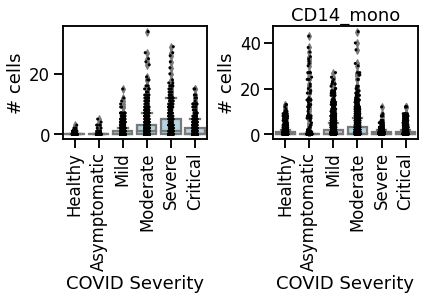

In [97]:
def plot_nhood_counts_by_severity(nhood_adata, n_ixs):
    pl_df = pd.DataFrame(nhood_adata[n_ixs].X.A, columns = nhood_adata.var_names).melt(var_name='sample_id', value_name='n_cells')
    pl_df = pd.merge(pl_df, nhood_adata.var)
    pl_df = pl_df[pl_df['severity_cont'] >= 0]
    pl_df['log_n_cells'] = np.log1p(pl_df['n_cells'])
    pl_df['severity_cont'] = [order_severity[i] for i in pl_df['severity_cont']]
    pl_df['severity_cont'] = pl_df['severity_cont'].astype('category').cat.reorder_categories(order_severity)
    sns.boxplot(data=pl_df, x='severity_cont', y='n_cells', color='lightblue');
    sns.stripplot(data=pl_df, x='severity_cont', y='n_cells', color='black', s=3);
    plt.xticks(rotation = 90); 
    plt.xlabel("COVID Severity"); plt.ylabel('# cells');

n_ixs = nhood_adata.obs_names[
    (nhood_adata.obs[ f'logFC_Critical'] > 0.5) & 
    (nhood_adata.obs['nhood_annotation'] == 'CD14_mono')
#                               & (nhood_adata.obs['logFC_severity_DAAsymptomatic-severity_DAHealthy'] > 2)
                             ]
plt.subplot(1,2,1);
plot_nhood_counts_by_severity(nhood_adata, n_ixs)

n_ixs = nhood_adata.obs_names[
    (nhood_adata.obs[ f'logFC_Asymptomatic'] > 0.5) & (nhood_adata.obs[ f'logFC_Severe'] < 0.1) &
    (nhood_adata.obs['nhood_annotation'] == 'CD14_mono')]
plt.subplot(1,2,2);
plot_nhood_counts_by_severity(nhood_adata, n_ixs);
plt.tight_layout();
plt.title('CD14_mono')

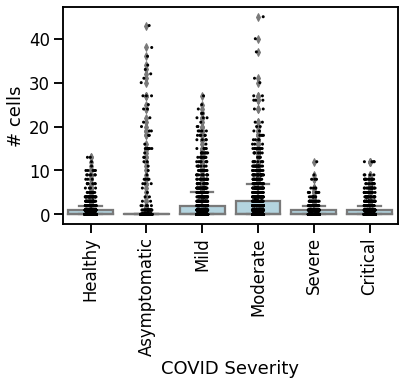